In [1]:

import sys
sys.path.insert(0, "..")

In [2]:

from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt


from lib.dataloader import DetectionDataLoader, RSNA24DF
from lib.model import DetectionModel
from lib.transformations import vertical_flip, horizontal_flip

import numpy as np

import pandas as pd

from sklearn.model_selection import KFold

from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import get_cosine_schedule_with_warmup

from lib.patientInfo import Scan, Img

In [3]:

DEBUG = False
DATA_DIR = "../data"
MODEL_NAME = "tf_efficientnet_b0.ns_jft_in1k" if DEBUG else "tf_efficientnet_b5.ns_jft_in1k"
DEVICE = "cuda:0"
MODEL_DIR = "/home/paradox/Desktop/ai/rsna-2024-lumbar-spine-degenerative-classification/models/sagittial_t2_stir"

EPOCHS = 20

HEIGHT = 512
WIDTH = 512

# Network params
N_CLASSES = 5
HIDDEN_DIM = 768
NORMALISE=255.0


WINDOW_WIDTH = None
WINDOW_CENTER = None
CHANGE_WINDOW=False

SEED = 8620
N_WORKERS=4

GRAD_ACC = 1
TGT_BATCH_SIZE = 16
BATCH_SIZE = TGT_BATCH_SIZE // GRAD_ACC
EARLY_STOPPING_EPOCH = 3
OUTPUT_DIR = "models/sagittial_t2_stir"

TEST_BATCH_SIZE = 1

N_FOLDS = 5

LR = 2e-4 * TGT_BATCH_SIZE / 32
AUG = True

In [4]:
train_df = pd.read_csv(f"{DATA_DIR}/train.csv")
train_df = train_df[train_df["study_id"] != 3008676218]
train_label_coordinates_df = pd.read_csv(f"{DATA_DIR}/train_label_coordinates.csv")
train_series_descriptions_df = pd.read_csv(f"{DATA_DIR}/train_series_descriptions.csv")

In [5]:
rsna24df = RSNA24DF(train_df, train_label_coordinates_df, train_series_descriptions_df, f"{DATA_DIR}/train_images")

In [6]:
class CanalSteneosisDataLoader(DetectionDataLoader):
    def __init__(self
             , patient_ids
             , positive_negative_ratio=0.5
             , positive_augment_prob=0.25
             , negative_augment_prob=0.15
             , rsna24DF=rsna24df
             , transformations=[]
             , height=HEIGHT
             , width=WIDTH
             , phase = "train"
             , window_width=WINDOW_WIDTH
             , window_center=WINDOW_CENTER
             , change_window=CHANGE_WINDOW
             , normalise=NORMALISE
             ) -> None:
        super().__init__(patient_ids=patient_ids 
                         , rsna24DF=rsna24DF
                         , transformations=transformations
                         , height=height 
                         , width=width 
                         , positive_negative_ratio=positive_negative_ratio 
                         , positive_augment_prob=positive_augment_prob 
                         , negative_augment_prob=negative_augment_prob
                         , phase=phase
                         , window_center=window_center
                         , window_width=window_width
                         , change_window=change_window
                         , normalise=normalise
                        )

    def _get_patient_scans(self, patient_info) -> list[Img]:
        return patient_info.get_scans(Scan.SagittalT2_STIR)
        
    def _mk_target_array(self, x, labels) -> tuple[np.ndarray, np.ndarray]:
        y_class, y_loc = np.zeros(N_CLASSES), np.zeros((N_CLASSES, 2))

        for label in labels:
            level = label.location.disc_level.to_int()
            y_class[level] = 1.0
            y_loc[level] = np.array([label.x, label.y])
        
        return y_class, y_loc

In [7]:

bce = nn.BCEWithLogitsLoss()
def criterion(y_class, y_loc, pred_class, pred_loc, alpha=0.01):
    
    class_loss = bce(pred_class, y_class)
    
    loc_loss = (((pred_loc - y_loc) ** 2).sum(-1).sqrt() * y_class).mean(-1).mean()

    return (class_loss + alpha * loc_loss), {"class_loss": class_loss, "loc_loss": loc_loss}


def train(model,dataloader, criterion, optimizer, scheduler=None, freeze_conv=False):
    
    model.train()
    optimizer.zero_grad()
    training_loss = []
    
    for idx, (x, y) in enumerate(pbar := tqdm(dataloader)):
        
        x, y_class, y_loc = x.to(DEVICE), y[0].to(DEVICE), y[1].to(DEVICE)
        
        with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
            pred_class, pred_loc = model(x, freeze_conv=freeze_conv)
            pred_loc = pred_loc.reshape(-1,N_CLASSES,2)
            loss, _ = criterion(y_class, y_loc, pred_class, pred_loc)
            loss = loss / GRAD_ACC
            
        loss.backward()
        norm = nn.utils.clip_grad_norm(model.parameters(), 1.0)

        training_loss.append(loss.item() * GRAD_ACC)

        if (idx + 1) % GRAD_ACC == 0:
            optimizer.step()
            optimizer.zero_grad()
            if scheduler is not None:
                scheduler.step()


        pbar.set_description(f"loss: {loss.item() * GRAD_ACC:.6f}, | norm: {norm:.4f}| training_loss: {np.mean(training_loss):.6f}")
        
    
    return np.mean(training_loss)

def validation(model, data_loader, criterion):
    
        model.eval()
    
        val_loss = []
        loc_loss = []
        class_loss = []

        with torch.no_grad():
    
            for idx, (x, y) in enumerate(pbar := tqdm(data_loader)):
                
                x, y_class, y_loc = x.to(DEVICE).squeeze(0).float(), y[0].to(DEVICE).squeeze(0), y[1].to(DEVICE).squeeze(0)

                with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
                    pred_class, pred_loc = model(x)
                    pred_loc = pred_loc.reshape(-1,N_CLASSES,2)
                    loss, per_cat_loss = criterion(y_class, y_loc, pred_class, pred_loc)

                val_loss.append(loss.item())
                loc_loss.append(per_cat_loss["loc_loss"].item())
                class_loss.append(per_cat_loss["class_loss"].item())
                
    
                pbar.set_description(f"current loss: {loss.item():.6f}, validation_loss: {np.mean(val_loss):.6f}, loc_loss: {np.mean(loc_loss)}, class_loss: {np.mean(class_loss)}")

        return np.mean(val_loss), np.mean(loc_loss), np.mean(class_loss)
    


In [8]:
skf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

In [11]:


for fold, (trn_idx, val_idx) in enumerate(skf.split(range(len(train_df)))):
    print('#'*30)
    print(f'start fold{fold}')
    print('#'*30)
    print(len(trn_idx), len(val_idx))

    df_train = train_df.iloc[trn_idx]
    df_valid = train_df.iloc[val_idx]
    
    train_ds = CanalSteneosisDataLoader(df_train["study_id"].unique(), phase='train', transformations=[vertical_flip, horizontal_flip])
    train_dl = DataLoader(
                train_ds,
                batch_size=BATCH_SIZE,
                shuffle=True,
                pin_memory=True,
                drop_last=True,
                num_workers=N_WORKERS
                )

    valid_ds = CanalSteneosisDataLoader(df_valid["study_id"].unique(), phase='valid', transformations=[])
    valid_dl = DataLoader(
                valid_ds,
                batch_size=1,
                shuffle=False,
                pin_memory=True,
                drop_last=False,
                num_workers=N_WORKERS
                )
    
    # model = DetectionModel(MODEL_NAME, n_classes=N_CLASSES, coord_dim=2, hidden_dim=HIDDEN_DIM).to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=LR)

    
    warmup_steps = EPOCHS/10 * len(train_dl) // GRAD_ACC
    num_total_steps = EPOCHS * len(train_dl) // GRAD_ACC
    num_cycles = 0.475
    scheduler = get_cosine_schedule_with_warmup(optimizer,
                                                num_warmup_steps=warmup_steps,
                                                num_training_steps=num_total_steps,
                                                num_cycles=num_cycles)

    best_val_loss   = 1.04
    best_loc_loss   = 23.73
    best_class_loss = 0.80
    early_stop_counter = 0
    
    for epoch in range(1, EPOCHS + 1):
        print(f"EPOCH: {epoch}")
        # _ = train(model, train_dl, criterion, optimizer, scheduler, freeze_conv=False)
        val_loss, loc_loss, class_loss = validation(model, valid_dl, criterion)

        print(f"val_loss: {val_loss:.4f} | loc_loss: {loc_loss:.4f} | class_loss: {class_loss:.4f}")

        if loc_loss < best_loc_loss:
            early_stop_counter = 0
            print(f"updating best_loc_loss from {best_loc_loss} to {loc_loss}")
            
            best_val_loss = val_loss
            best_loc_loss = loc_loss
            best_class_loss = class_loss

            print(f"updated losses: {best_val_loss=}, {best_loc_loss=}, {best_class_loss=}")

            # print("Saving model....")
            # fname = f'../models/sagittial_t2_stir/best_loc_model_fold-{fold}.pt'
            # torch.save(model.state_dict(), fname)
            
        else:
            early_stop_counter += 1
            print(f"{EARLY_STOPPING_EPOCH - early_stop_counter} more epochs to train until early stopping")

        if early_stop_counter == EARLY_STOPPING_EPOCH:
            break
    break
 

##############################
start fold0
##############################
1579 395
EPOCH: 1


current loss: 0.068970, validation_loss: 0.117735, loc_loss: 1.9165098514518562, class_loss: 0.09856967566076431: 100%|██████████████████████████████████████████████████████████| 395/395 [00:17<00:00, 22.92it/s]


val_loss: 0.1177 | loc_loss: 1.9165 | class_loss: 0.0986
updating best_loc_loss from 23.73 to 1.9165098514518562
updated losses: best_val_loss=0.11773477417528286, best_loc_loss=1.9165098514518562, best_class_loss=0.09856967566076431
EPOCH: 2


current loss: 0.023109, validation_loss: 0.118559, loc_loss: 1.9855577251272376, class_loss: 0.09870359546243002:  28%|████████████████                                          | 109/395 [00:04<00:12, 23.04it/s]


KeyboardInterrupt: 

In [9]:
model = DetectionModel(MODEL_NAME, n_classes=N_CLASSES, coord_dim=2, hidden_dim=HIDDEN_DIM).to(DEVICE)

model.load_state_dict(torch.load("../models/sagittial_t2_stir/best_loc_model_fold-0.pt"))
model.eval()
ds = CanalSteneosisDataLoader(train_df["study_id"])

Unexpected keys (bn2.bias, bn2.num_batches_tracked, bn2.running_mean, bn2.running_var, bn2.weight, classifier.bias, classifier.weight, conv_head.weight) found while loading pretrained weights. This may be expected if model is being adapted.


(1, 512, 512)
[1. 1. 1. 1. 1.]
[[291.09677419 154.37992832]
 [275.49820789 205.76344086]
 [265.40501792 254.39426523]
 [258.98207885 305.77777778]
 [272.74551971 344.31541219]]
[0.96656823 0.98548    0.9911781  0.99017185 0.9839436 ]
[[283.35355 153.29953]
 [273.85385 211.05048]
 [270.55557 265.39548]
 [270.5731  314.73917]
 [281.07822 359.54495]]


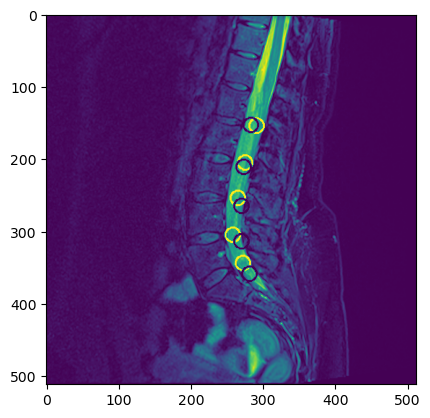

In [16]:
import random

idx = random.choice([*range(len(train_df["study_id"]))])
x, (y_class, y_loc) = ds[3]
print(x.shape)
print(y_class)
print(y_loc)

print("==========")


with torch.no_grad():
    t_x = torch.from_numpy(x).unsqueeze(0).to(DEVICE)
    pred_class, pred_loc = model(t_x)

    pred_class = pred_class.sigmoid().squeeze().cpu().numpy()
    pred_loc = pred_loc.squeeze().cpu().numpy().reshape(N_CLASSES,2)
    
    print(pred_class)
    print(pred_loc)
          


x = x.squeeze()
x = cv2.normalize(x, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

for idx in range(N_CLASSES):
    c = (int(y_loc[idx, 0]), int(y_loc[idx,1]))
    x = cv2.circle(x.copy(), c, 10, (255,192,203), 2)
    
    c = (int(pred_loc[idx, 0]), int(pred_loc[idx,1]))
    x = cv2.circle(x.copy(), c, 10, (0,255,0), 2)

plt.imshow(x)
plt.show()